In [1]:
TRAIN_DIR = 'data/dev_data/dev_data/slider/train'
TEST_DIR = 'data/dev_data/dev_data/slider/test'
SAMPLE_RATE = 16000
DOWNSAMPLE_FACTOR = 10
RANDOM_STATE = 42

In [2]:
import os
import pandas as pd
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objs as go

In [3]:
XTRdic = dict()
for file_name in os.listdir(TRAIN_DIR):
    file_path = os.path.join(TRAIN_DIR, file_name)
    _, audio_data = wavfile.read(file_path)
    id = file_name.split('_')[2]
    if id in XTRdic:
        XTRdic[id].append(np.array(audio_data[::DOWNSAMPLE_FACTOR]))
    else:
        XTRdic[id] = [audio_data[::DOWNSAMPLE_FACTOR]]

In [4]:
XTEdic = dict()
yTEdic = dict()
for file_name in os.listdir(TEST_DIR):
    file_path = os.path.join(TEST_DIR, file_name)
    _, audio_data = wavfile.read(file_path)
    parts = file_name.split('_')
    id = parts[2]
    label = 1 if parts[0] == 'anomaly' else 0
    if id in XTEdic:
        XTEdic[id].append(np.array(audio_data[::DOWNSAMPLE_FACTOR]))
        yTEdic[id].append(label)
    else:
        XTEdic[id] = [audio_data[::DOWNSAMPLE_FACTOR]]
        yTEdic[id] = [label]

In [5]:
ids = sorted(XTRdic.keys())
for id in ids:
    XTRdic[id] = np.vstack(XTRdic[id])
    XTEdic[id] = np.vstack(XTEdic[id])
    yTEdic[id] = np.array(yTEdic[id])

In [6]:
import librosa

def estimate_pitch(audio_data):
    # Estimate pitch using librosa
    pitches, magnitudes = librosa.piptrack(y=audio_data.astype(float), sr=SAMPLE_RATE/DOWNSAMPLE_FACTOR)
    
    return pitches

def pitch_similarity(pitches1, pitches2):
    # Compute Euclidean distance between pitch values
    distance = np.linalg.norm(pitches1 - pitches2)
    
    # Convert distance to similarity score (e.g., inverse)
    similarity = 1 / (1 + distance)
    
    return similarity

def correlation(signal1, signal2):
    return np.mean(np.abs(signal1*signal2))

def compute_mfcc(audio_data, n_mfcc=13):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio_data.astype(float), sr=SAMPLE_RATE/DOWNSAMPLE_FACTOR, n_mfcc=n_mfcc)
    
    return mfccs

def mfcc_distance(mfcc1, mfcc2):
    distance = euclidean(mfcc1.flatten(), mfcc2.flatten())
    return distance

def fft_distance(signal1, signal2):
    distance = euclidean(signal1.flatten(), signal2.flatten())
    return distance

In [10]:
for id in ids:
    XTR = XTRdic[id]
    XTRmean = np.mean(XTR, axis=0)
    mfcc = compute_mfcc(XTRmean)
    fft = np.fft.fft(XTRmean)
    # avg = fft.mean()

    print(XTRmean.shape)

    scores = []
    for i in range(len(XTR)):
        corr = correlation(XTR[i,:], XTRmean)
        md = mfcc_distance(compute_mfcc(XTR[i,:]), mfcc)
        thisfft = np.fft.fft(XTR[i,:])
        fd = fft_distance(thisfft, fft)
        # fa = avg - thisfft.mean()
        peaks, _ = find_peaks(XTR[i,:])
        scores.append([corr, md, fd])
    scores = np.array(scores)
    print(scores.shape)
    
    # Convert scores to numpy array for easier manipulation
    scores = np.array(scores)

    # Separate the two dimensions
    x = scores[:, 0]
    y = scores[:, 1]
    z = scores[:, 2]

    #     colors = np.where(yTE == 0, 'red', 'blue')
    
    # Create a trace
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=3,
            color=z,                # Color by z value
            colorscale='Viridis',   # Set color scale
            opacity=0.8
        )
    )
    # Create layout
    layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        )
    )
    # Create figure
    fig = go.Figure(data=[trace], layout=layout)

    # Show plot
    fig.show()


    # Create scatter plot
    # plt.scatter(score1, score2, c=colors)
    # plt.xlabel('Score 1')
    # plt.ylabel('Score 2')
    # plt.title('Scatter Plot of Scores')
    # plt.show()

(16000,)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
idx = 0
for id in ids:
    XTR = np.mean(XTRdic[id], axis=0)
    mfcc = compute_mfcc(XTR)
    fft = np.fft.fft(XTR)
    avg = fft.mean()
    XTE = XTEdic[id]
    yTE = yTEdic[id]

    print(XTR.shape)
    print(XTE.shape)

    scores = []
    for i in range(len(XTE)):
        # thisfft = np.fft.fft(XTE[i,:])
        # dist0 = thisfft.T @ thisfft
        # dist0 = dist0*np.conj(dist0)
        # fa = thisfft.mean()
        corr = correlation(XTR, XTE[i,:])
        md = mfcc_distance(compute_mfcc(XTE[i,:]), mfcc)
        thisfft = np.fft.fft(XTE[i,:])
        fd = fft_distance(thisfft, fft)
        fa = avg - thisfft.mean()
        
        peaks, _ = find_peaks(np.abs(np.clip(thisfft-fft, 0, None)), height=40000)
        scores.append([corr, md])
    scores = np.array(scores)
    print(scores.shape, yTE.shape)
    
    # Convert scores to numpy array for easier manipulation
    scores = np.array(scores)

    # # Separate the two dimensions
    # x = scores[:, 0]
    # y = scores[:, 1]
    # z = scores[:, 2]
    
    # # Filter scores based on class
    # scores_red = scores[yTE == 0]
    # scores_blue = scores[yTE == 1]
    
    # # Define colors for the classes (assuming yTE is defined)
    # colors = np.where(yTE == 0, 'red', 'blue')
    
    # # Create a trace
    # trace = go.Scatter3d(
    #     x=x,
    #     y=y,
    #     z=z,
    #     mode='markers',
    #     marker=dict(
    #         size=3,
    #         color=colors,                # Color by z value
    #         colorscale='Viridis',   # Set color scale
    #         opacity=0.8
    #     ),
    # )
    # # Create layout
    # layout = go.Layout(
    # margin=dict(l=0, r=0, b=0, t=0),
    # scene=dict(
    #         xaxis=dict(title='X'),
    #         yaxis=dict(title='Y'),
    #         zaxis=dict(title='Z'),
    #     )
    # )
    # # Create figure
    # fig = go.Figure(data=[trace], layout=layout)

    # # Show plot
    # fig.show()
    
    colors = np.where(yTE == 0, 'red', 'blue')

    ax[idx].scatter(scores[:,0], scores[:,1], c=colors, label=colors)
    ax[idx].set_xlabel('Correlation')
    ax[idx].set_ylabel('MFCC distance')
    ax[idx].set_title(f'ID = {id}')
        
    idx += 1

plt.show()

In [11]:
XTRfeatures = dict()
XTRmeans = dict()

for id in ids:
    print(f'Processing {id}')
    XTR = XTRdic[id]
    XTRmean = np.mean(XTR, axis=0)
    mfcc = compute_mfcc(XTRmean)
    fft = np.fft.fft(XTRmean)
    avg = fft.mean()
    pitches = estimate_pitch(XTRmean)

    features = []
    for i in range(len(XTR)):
        corr = correlation(XTR[i,:], XTRmean)
        md = mfcc_distance(compute_mfcc(XTR[i,:]), mfcc)
        thisfft = np.fft.fft(XTR[i,:])
        fd = fft_distance(thisfft, fft)
        fa = avg - thisfft.mean()
        thispitches = estimate_pitch(XTR[i,:])
        ps = pitch_similarity(pitches, thispitches)
        peaks, _ = find_peaks(XTR[i,:])
        features.append([corr, md, fd, fa.real, fa.imag, ps, len(peaks)])
    
    XTRfeatures[id] = np.array(features)
    XTRmeans[id] = {
        'mean': XTRmean,
        'mfcc': mfcc,
        'fft': fft,
        'avgfft-real': avg.real,
        'avgfft-imag': avg.imag,
        'pitches': pitches
    }

Processing 00
Processing 02
Processing 04


In [85]:
display([x['mean'] for x in XTRmeans.values()])

[array([-10.55681818, -14.15702479,  -3.49173554, ...,   9.30785124,
          7.38119835,  -6.81404959]),
 array([-14.96900826,  -6.60227273,   3.48243802, ...,  -5.09917355,
         -2.07334711,   7.5857438 ]),
 array([-18.66359447,  16.57142857, -16.35253456, ...,  -2.73502304,
         -1.64285714, -13.62442396])]

In [94]:
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import multivariate_normal

# scalers = dict()
# gaussians = dict()
# thresholds = dict()

# for id in ids:
#     print(f'Processing {id}')
#     XTR = XTRfeatures[id]
    
#     scaler = StandardScaler()
#     XTRscaled = scaler.fit_transform(XTR)
#     scalers[id] = scaler

#     # Estimate mean and covariance matrix from normalized data
#     mean = np.mean(XTRscaled, axis=0)
#     covariance_matrix = np.cov(XTRscaled, rowvar=False)

#     gaussian_distribution = multivariate_normal(mean=mean, cov=covariance_matrix)
#     gaussians[id] = gaussian_distribution

#     log_likelihoods = gaussian_distribution.logpdf(XTRscaled)
#     log_likelihoods.sort()
#     threshold = log_likelihoods[int(0.1*len(log_likelihoods))]
#     thresholds[id] = threshold

In [95]:
# loglikelihoods = dict()

# for id in ids:
#     print(f'Processing {id}')
#     XTE = XTEdic[id]
#     yTE = yTEdic[id]
    
#     features = []
#     for i in range(len(XTE)):
#         thisfft = np.fft.fft(XTE[i,:])
#         pc = phase_correlation(XTE[i,:], XTRmeans[id]['mean'])
#         md = mfcc_distance(compute_mfcc(XTE[i,:]), XTRmeans[id]['mfcc'])
#         fd = fft_distance(thisfft, XTRmeans[id]['fft'])
#         fa = XTRmeans[id]['avgfft-real'] - thisfft.mean()
#         peaks, _ = find_peaks(XTE[i,:])
#         features.append([pc, md, fd, fa.real, fa.imag, len(peaks)])
    
#     XTEfeatures = np.array(features)

#     # Normalize test data using the same scaler
#     XTEscaled = scalers[id].transform(XTEfeatures)

#     # Compute log-likelihood of the test data
#     log_likelihood = gaussians[id].logpdf(XTEscaled)
#     loglikelihoods[id] = log_likelihood

In [96]:
# from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# for id in ids:
#     threshold = thresholds[id]
#     yTE = yTEdic[id]
#     colors = np.where(yTE == 0, 'red', 'blue')
#     print(f'Processing {id}')
#     log_likelihood = loglikelihoods[id]
#     # Create a scatter plot
#     plt.scatter(range(len(log_likelihood)), log_likelihood, c=colors)

#     # Add labels and title
#     plt.xlabel('Sample')
#     plt.ylabel('Log-Likelihood')
#     plt.title('Scatter Plot of Log-Likelihoods')

#     # Show the plot
#     plt.show()

#     ypred = np.where(log_likelihood > threshold, 1, 0)
#     accuracy = accuracy_score(yTE, ypred)
#     auc = roc_auc_score(yTE, ypred)
#     conf_mat = confusion_matrix(yTE, ypred)
#     # Extract TN, FP, FN, TP from confusion matrix
#     TN, FP, FN, TP = conf_mat.ravel()
#     # Compute False Positive Rate (FPR)
#     fpr = FP / (FP + TN)
#     # Compute False Negative Rate (FNR)
#     fnr = FN / (FN + TP)

#     print(f'AUC: {auc:.2f}')
#     print(f'Accuracy: {accuracy:.2f}')
#     print(f'FPR: {fpr:.2f}')
#     print(f'FNR: {fnr:.2f}')
#     print('Confusion Matrix:')
#     print(conf_mat)

In [12]:
from sklearn.preprocessing import StandardScaler

XTRfinal = dict()
XTEfinal = dict()

for id in ids:
    print(f'Processing {id}')
    XTR = XTRfeatures[id]
    scaler = StandardScaler()
    XTRscaled = scaler.fit_transform(XTR)

    XTE = XTEdic[id]
    yTE = yTEdic[id]
    features = []

    for i in range(len(XTE)):
        thisfft = np.fft.fft(XTE[i,:])
        corr = correlation(XTRmeans[id]['mean'], XTE[i,:])
        md = mfcc_distance(compute_mfcc(XTE[i,:]), XTRmeans[id]['mfcc'])
        fd = fft_distance(thisfft, XTRmeans[id]['fft'])
        thisfftmean = thisfft.mean()
        fare = XTRmeans[id]['avgfft-real'] - thisfftmean.real
        faim = XTRmeans[id]['avgfft-imag'] - thisfftmean.imag
        peaks, _ = find_peaks(XTE[i,:])
        thispitches = estimate_pitch(XTE[i,:])
        ps = pitch_similarity(XTRmeans[id]['pitches'], thispitches)
        features.append([corr, md, fd, fare, faim, ps, len(peaks)])
    
    XTEfeatures = np.array(features)
    # Normalize test data using the same scaler
    XTEscaled = scaler.transform(XTEfeatures)
    
    XTRfinal[id] = XTRscaled
    XTEfinal[id] = XTEscaled

Processing 00
Processing 02
Processing 04


array([[ 1.00042212,  0.08254243,  0.65995908,  0.0184816 , -0.01116386,
         0.27739473, -0.05453289],
       [ 0.08254243,  1.00042212,  0.04132295,  0.00166041,  0.01758188,
        -0.81622299,  0.1409014 ],
       [ 0.65995908,  0.04132295,  1.00042212, -0.00265355, -0.03687934,
         0.17629187, -0.08924729],
       [ 0.0184816 ,  0.00166041, -0.00265355,  1.00042212, -0.01337028,
        -0.00344886, -0.00865811],
       [-0.01116386,  0.01758188, -0.03687934, -0.01337028,  1.00042212,
        -0.01052937,  0.00805729],
       [ 0.27739473, -0.81622299,  0.17629187, -0.00344886, -0.01052937,
         1.00042212, -0.26849532],
       [-0.05453289,  0.1409014 , -0.08924729, -0.00865811,  0.00805729,
        -0.26849532,  1.00042212]])

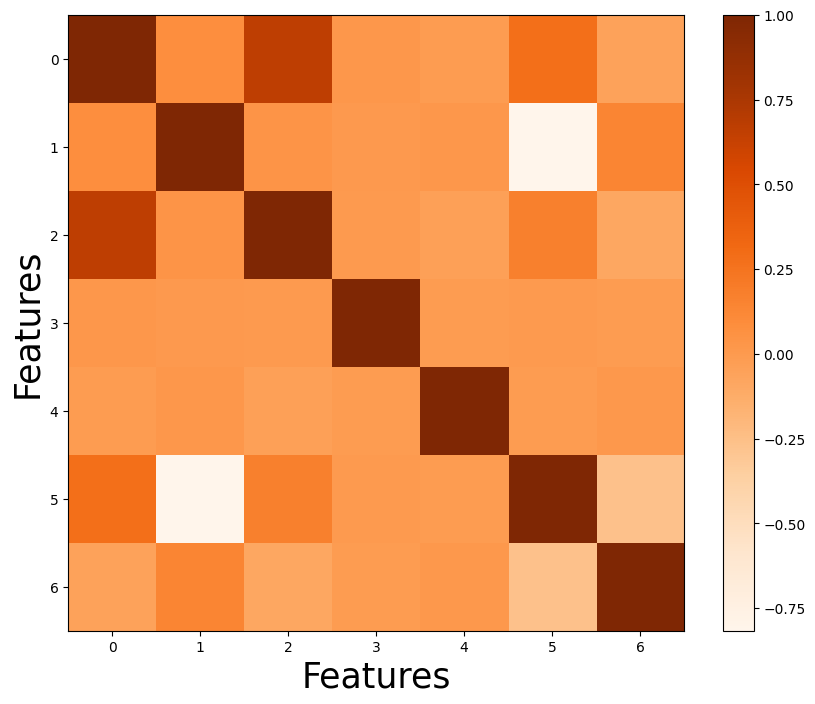

In [13]:
XTR = np.vstack([XTRfinal[id] for id in ids])
import matplotlib.pyplot as plt

# Calculate the covariance matrix
cov_matrix = np.cov(XTR.T)

display(cov_matrix)
# Plot the covariance matrix
plt.figure(figsize=(10, 8))
plt.imshow(cov_matrix, cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.xlabel('Features', fontdict={'fontsize': 25})
plt.ylabel('Features', fontdict={'fontsize': 25})
plt.show()

>>>>>     PCA(2) | GMM components: 1 | Covariance: diag     <<<<<
AUC: 0.944, F1-score: 0.876, Accuracy: 0.837, FPR: 0.040, FNR: 0.210


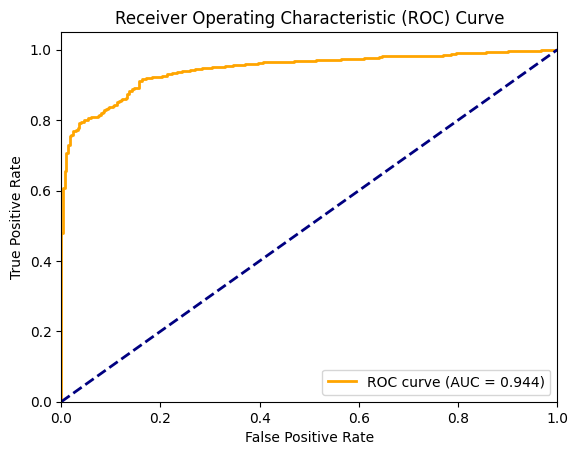

>>>>>     PCA(2) | GMM components: 2 | Covariance: diag     <<<<<
AUC: 0.940, F1-score: 0.878, Accuracy: 0.839, FPR: 0.043, FNR: 0.205


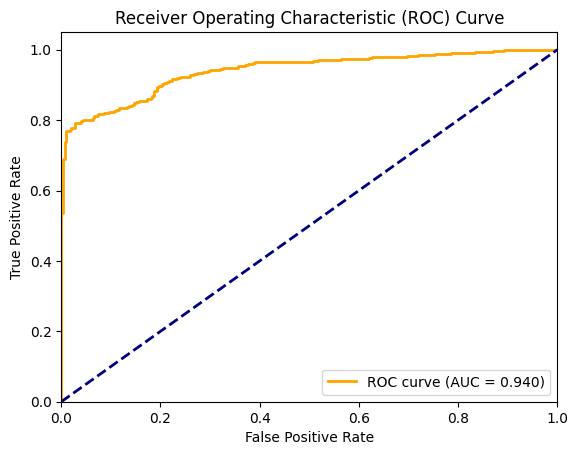

>>>>>     PCA(2) | GMM components: 4 | Covariance: diag     <<<<<
AUC: 0.953, F1-score: 0.921, Accuracy: 0.891, FPR: 0.053, FNR: 0.130


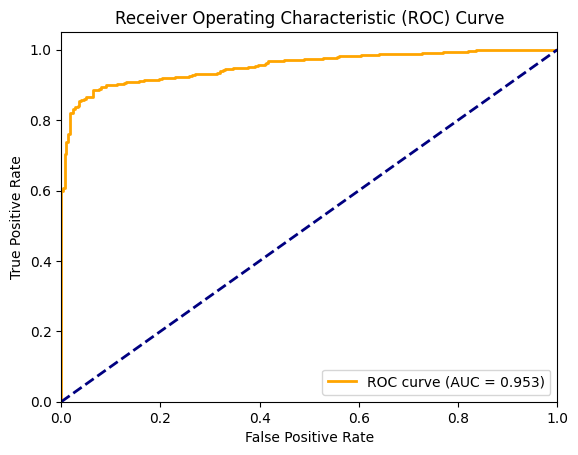

>>>>>     PCA(2) | GMM components: 8 | Covariance: diag     <<<<<
AUC: 0.956, F1-score: 0.922, Accuracy: 0.892, FPR: 0.063, FNR: 0.125


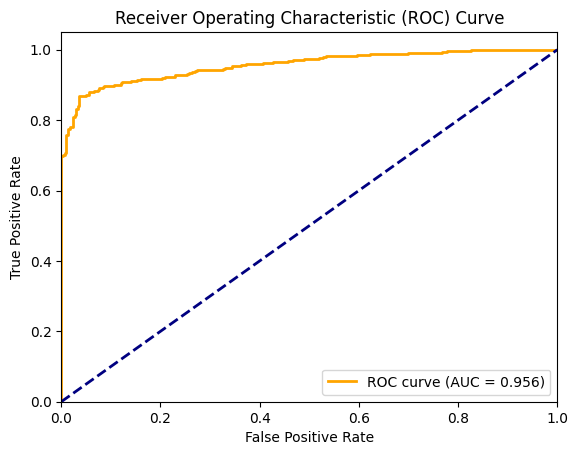

>>>>>     PCA(2) | GMM components: 16 | Covariance: diag     <<<<<
AUC: 0.958, F1-score: 0.925, Accuracy: 0.896, FPR: 0.080, FNR: 0.114


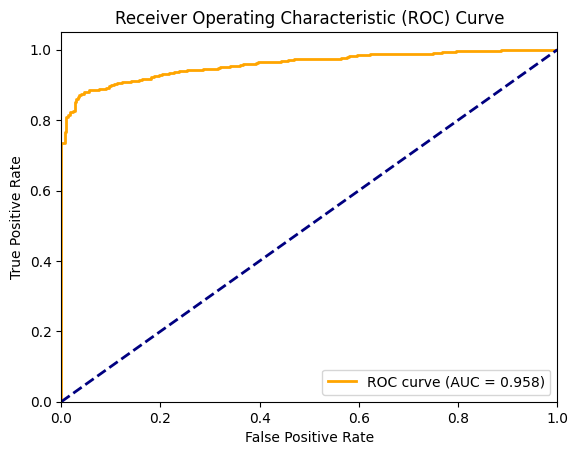

>>>>>     PCA(3) | GMM components: 1 | Covariance: diag     <<<<<
AUC: 0.934, F1-score: 0.857, Accuracy: 0.815, FPR: 0.050, FNR: 0.236


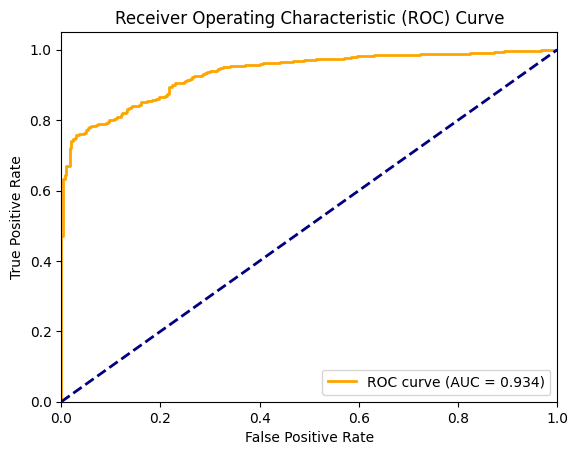

>>>>>     PCA(3) | GMM components: 2 | Covariance: diag     <<<<<
AUC: 0.931, F1-score: 0.866, Accuracy: 0.825, FPR: 0.050, FNR: 0.222


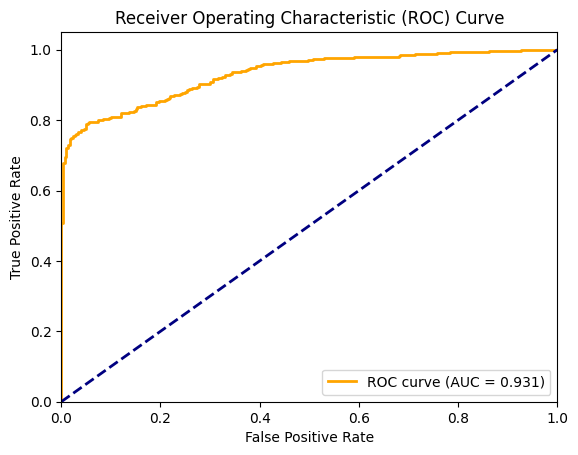

>>>>>     PCA(3) | GMM components: 4 | Covariance: diag     <<<<<
AUC: 0.938, F1-score: 0.884, Accuracy: 0.846, FPR: 0.057, FNR: 0.191


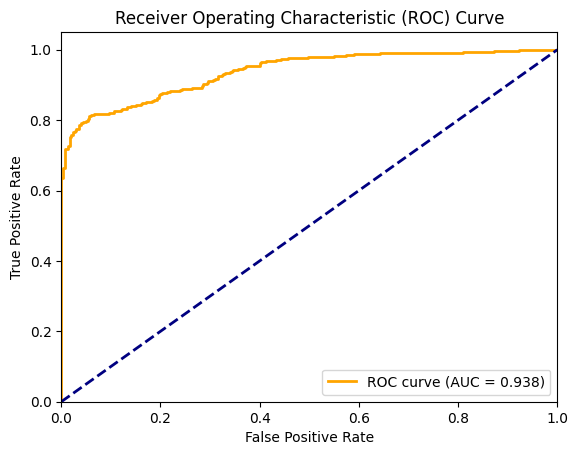

>>>>>     PCA(3) | GMM components: 8 | Covariance: diag     <<<<<
AUC: 0.951, F1-score: 0.900, Accuracy: 0.864, FPR: 0.070, FNR: 0.161


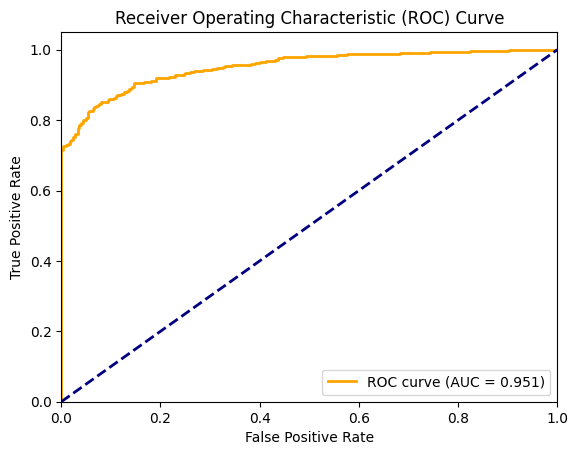

>>>>>     PCA(3) | GMM components: 16 | Covariance: diag     <<<<<
AUC: 0.954, F1-score: 0.915, Accuracy: 0.883, FPR: 0.077, FNR: 0.132


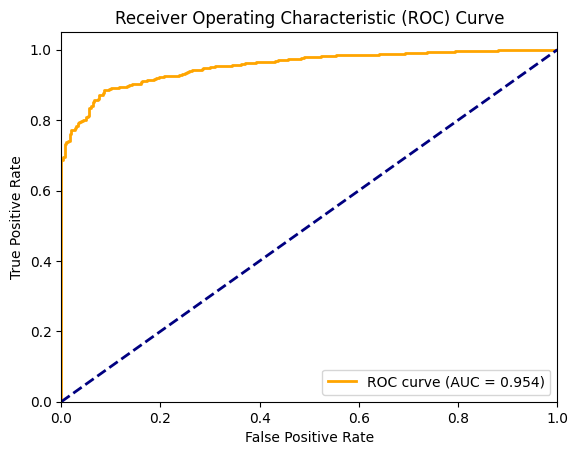

>>>>>     PCA(4) | GMM components: 1 | Covariance: diag     <<<<<
AUC: 0.926, F1-score: 0.846, Accuracy: 0.803, FPR: 0.047, FNR: 0.253


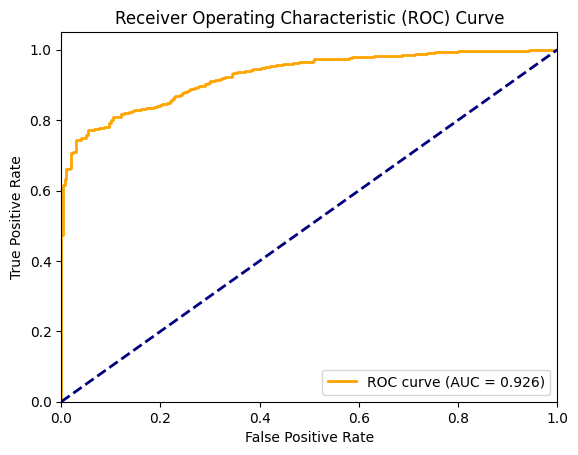

>>>>>     PCA(4) | GMM components: 2 | Covariance: diag     <<<<<
AUC: 0.925, F1-score: 0.854, Accuracy: 0.812, FPR: 0.043, FNR: 0.242


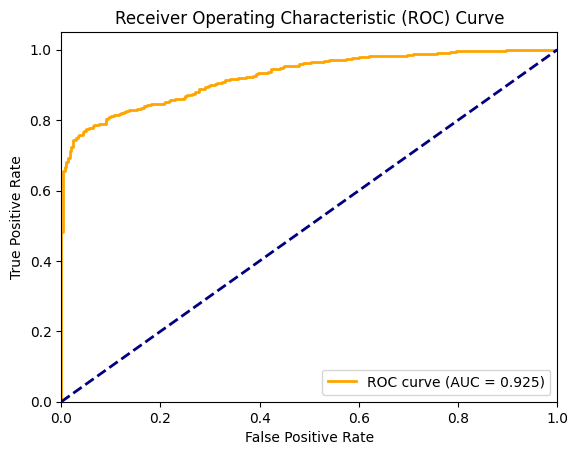

>>>>>     PCA(4) | GMM components: 4 | Covariance: diag     <<<<<
AUC: 0.934, F1-score: 0.870, Accuracy: 0.830, FPR: 0.043, FNR: 0.217


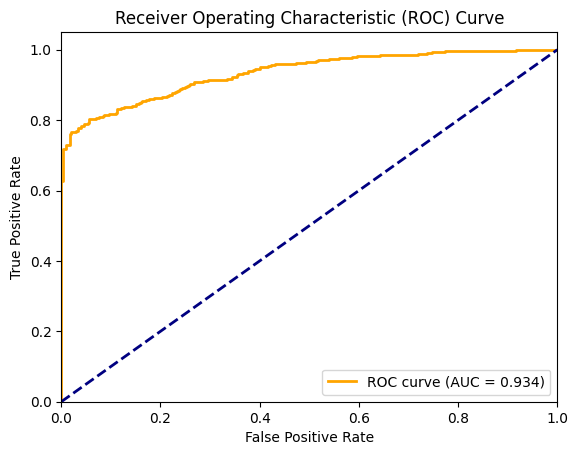

>>>>>     PCA(4) | GMM components: 8 | Covariance: diag     <<<<<
AUC: 0.943, F1-score: 0.870, Accuracy: 0.828, FPR: 0.060, FNR: 0.213


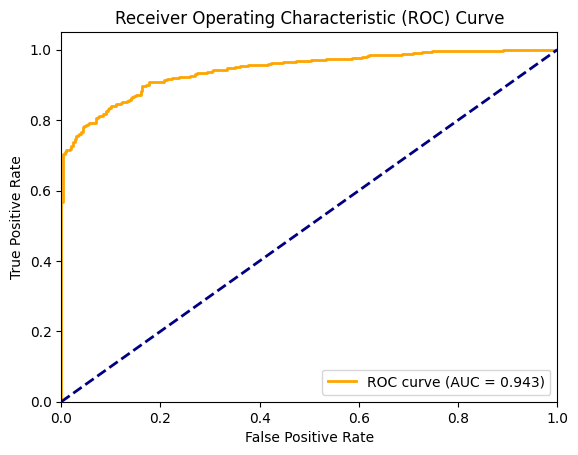

>>>>>     PCA(4) | GMM components: 16 | Covariance: diag     <<<<<
AUC: 0.945, F1-score: 0.881, Accuracy: 0.840, FPR: 0.087, FNR: 0.187


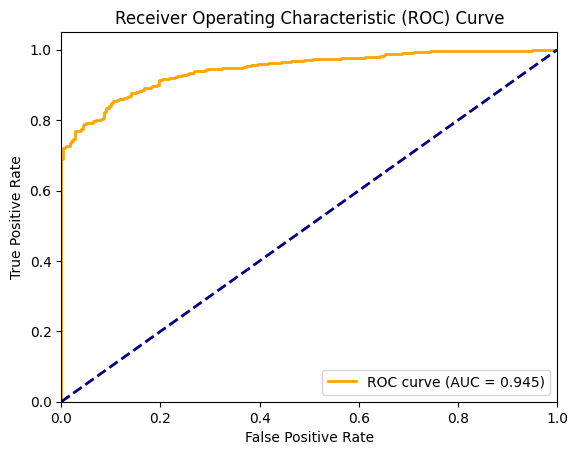

>>>>>     PCA(5) | GMM components: 1 | Covariance: diag     <<<<<
AUC: 0.916, F1-score: 0.839, Accuracy: 0.793, FPR: 0.067, FNR: 0.260


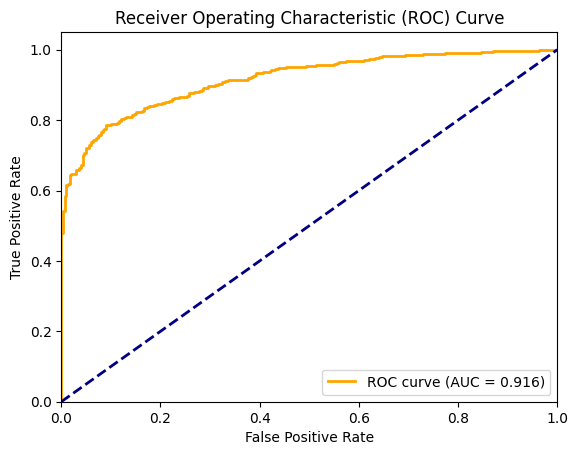

>>>>>     PCA(5) | GMM components: 2 | Covariance: diag     <<<<<
AUC: 0.916, F1-score: 0.845, Accuracy: 0.800, FPR: 0.063, FNR: 0.251


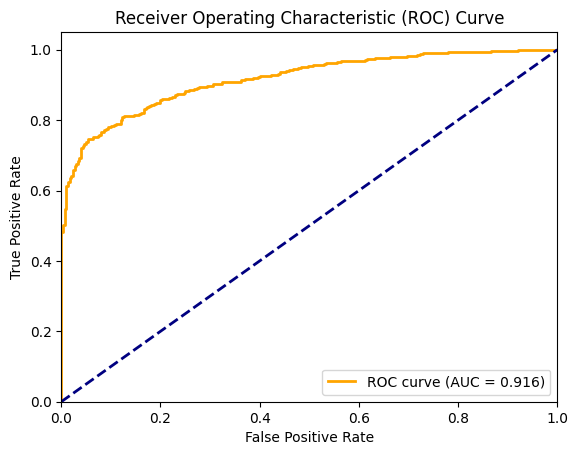

>>>>>     PCA(5) | GMM components: 4 | Covariance: diag     <<<<<
AUC: 0.908, F1-score: 0.817, Accuracy: 0.767, FPR: 0.090, FNR: 0.286


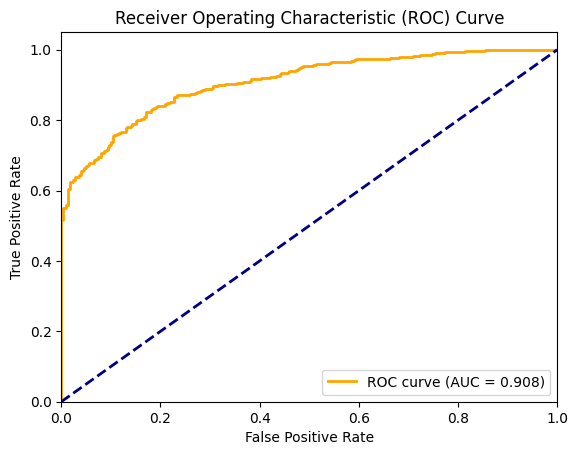

>>>>>     PCA(5) | GMM components: 8 | Covariance: diag     <<<<<
AUC: 0.926, F1-score: 0.863, Accuracy: 0.819, FPR: 0.090, FNR: 0.215


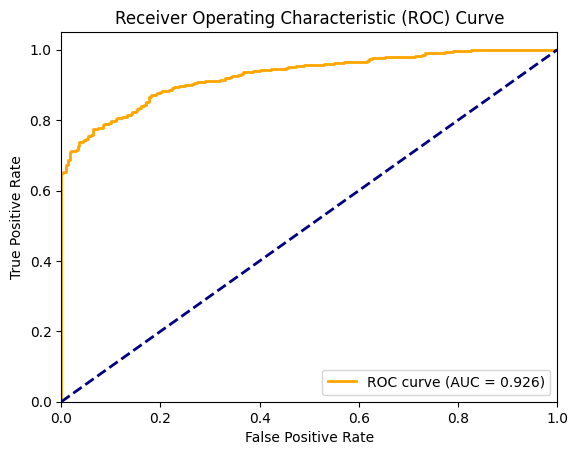

>>>>>     PCA(5) | GMM components: 16 | Covariance: diag     <<<<<
AUC: 0.934, F1-score: 0.879, Accuracy: 0.836, FPR: 0.127, FNR: 0.179


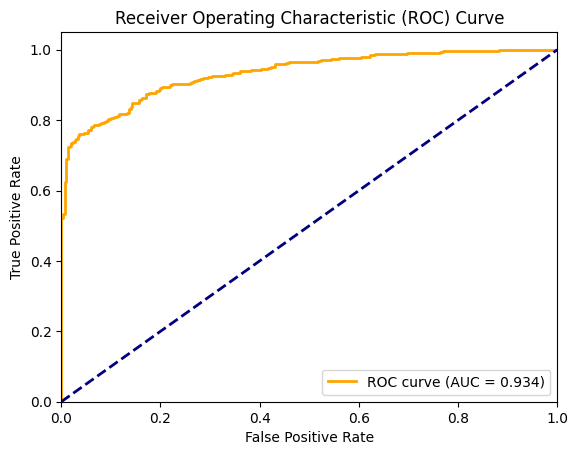

In [55]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, f1_score

best_gmm = None
best_auc = 0

nums_components = [1, 2, 4, 8, 16]
pcas = [2, 3, 4, 5]
covariances = ['diag']
# percentages = [0.02, 0.05, 0.08, 0.1]
percentage = 0.05

for pca_dims in pcas:
    for n_components in nums_components:
        for cov in covariances:
            print(f'>>>>>     PCA({pca_dims}) | GMM components: {n_components} | Covariance: {cov}     <<<<<')

            yTEtotal = []
            ypredtotal = []
            scorestotal = []
            models = dict()
            for id in ids:
                XTR = XTRfinal[id]
                XTE = XTEfinal[id]
                yTE = yTEdic[id]

                pca = PCA(n_components=pca_dims)
                XTR = pca.fit_transform(XTR)
                XTE = pca.transform(XTE)
                # if pca_dims == 2:
                #     covar = np.cov(XTR.T)
                #     print(covar)

                gmm = GaussianMixture(n_components=n_components, max_iter=10000, covariance_type=cov, random_state=42)
                gmm.fit(XTR)
                log_likelihoods = 1-gmm.score_samples(XTR)
                log_likelihoods.sort()
                threshold = log_likelihoods[int((1-percentage)*len(log_likelihoods))]

                test_scores = 1-gmm.score_samples(XTE)
                ypred = test_scores > threshold

                yTEtotal.extend(yTE)
                ypredtotal.extend(ypred)
                scorestotal.extend(test_scores)

                accuracy = accuracy_score(yTE, ypred)
                auc = roc_auc_score(yTE, test_scores)
                f1 = f1_score(yTE, ypred)
                conf_mat = confusion_matrix(yTE, ypred)
                TN, FP, FN, TP = conf_mat.ravel()
                fpr = FP / (FP + TN)
                fnr = FN / (FN + TP)

                # print(f'ID: {id}, AUC: {auc:.3f}, F1-score: {f1:.3f}, Accuracy: {accuracy:.3f}, FPR: {fpr:.3f}, FNR: {fnr:.3f}')

                models[id] = gmm

            fprs, tprs, thresholds = roc_curve(yTEtotal, scorestotal)

            accuracy = accuracy_score(yTEtotal, ypredtotal)
            auc = roc_auc_score(yTEtotal, scorestotal)
            f1 = f1_score(yTEtotal, ypredtotal)
            conf_mat = confusion_matrix(yTEtotal, ypredtotal)
            TN, FP, FN, TP = conf_mat.ravel()
            fpr = FP / (FP + TN)
            fnr = FN / (FN + TP)

            print(f'AUC: {auc:.3f}, F1-score: {f1:.3f}, Accuracy: {accuracy:.3f}, FPR: {fpr:.3f}, FNR: {fnr:.3f}')

            # Plot the ROC curve
            plt.figure()
            plt.plot(fprs, tprs, color='orange', lw=2, label='ROC curve (AUC = %0.3f)' % auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

            if auc > best_auc:
                best_auc = auc
                best_gmm = {
                    'pca': pca_dims,
                    'n_components': n_components,
                    'covariance': cov,
                    'model': models,
                    'auc': auc,
                }

In [56]:
print(best_auc)
display(best_gmm)

0.9583187682064087


{'pca': 2,
 'n_components': 16,
 'covariance': 'diag',
 'model': {'00': GaussianMixture(covariance_type='diag', max_iter=10000, n_components=16,
                  random_state=42),
  '02': GaussianMixture(covariance_type='diag', max_iter=10000, n_components=16,
                  random_state=42),
  '04': GaussianMixture(covariance_type='diag', max_iter=10000, n_components=16,
                  random_state=42)},
 'auc': 0.9583187682064087}

>>>>>     PCA(2), nu=0.1, gamma=0.001     <<<<<
AUC: 0.945, F1-score: 0.768, Accuracy: 0.726, FPR: 0.003, FNR: 0.376


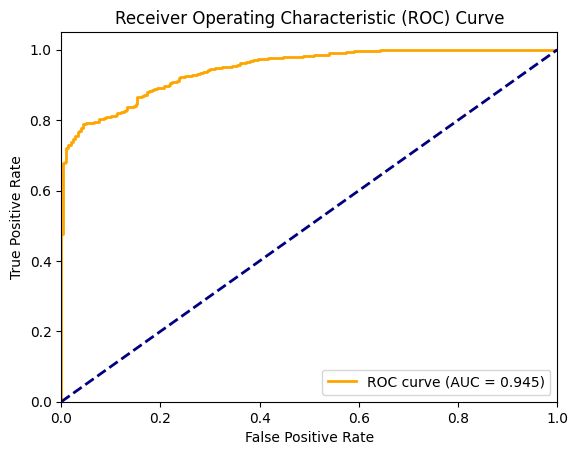

>>>>>     PCA(2), nu=0.1, gamma=0.01     <<<<<
AUC: 0.949, F1-score: 0.875, Accuracy: 0.836, FPR: 0.043, FNR: 0.210


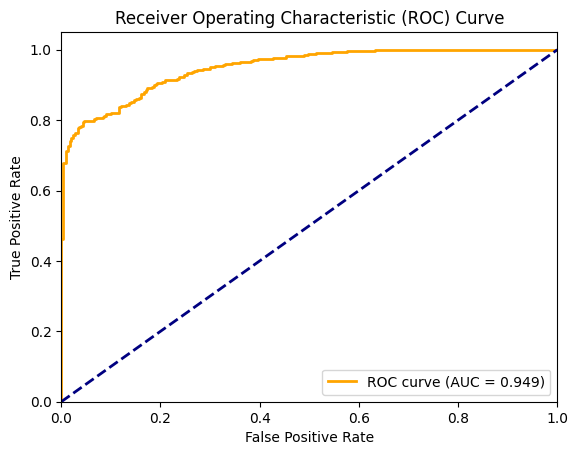

>>>>>     PCA(2), nu=0.1, gamma=0.1     <<<<<
AUC: 0.966, F1-score: 0.923, Accuracy: 0.894, FPR: 0.050, FNR: 0.127


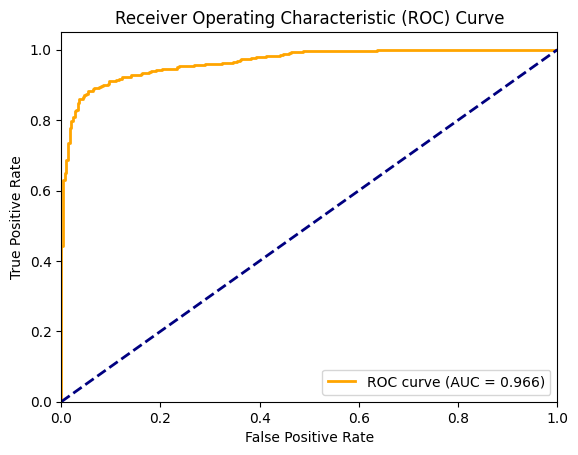

>>>>>     PCA(2), nu=0.3, gamma=0.001     <<<<<
AUC: 0.942, F1-score: 0.885, Accuracy: 0.845, FPR: 0.093, FNR: 0.179


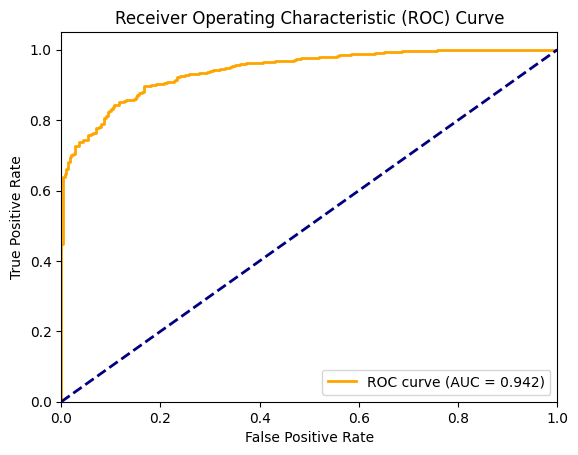

>>>>>     PCA(2), nu=0.3, gamma=0.01     <<<<<
AUC: 0.943, F1-score: 0.918, Accuracy: 0.878, FPR: 0.263, FNR: 0.069


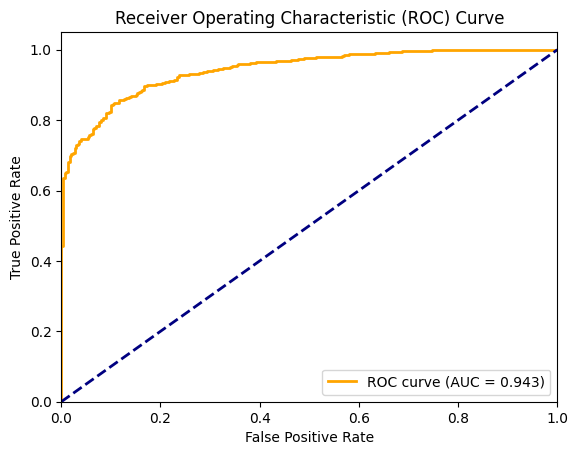

>>>>>     PCA(2), nu=0.3, gamma=0.1     <<<<<
AUC: 0.951, F1-score: 0.920, Accuracy: 0.882, FPR: 0.267, FNR: 0.062


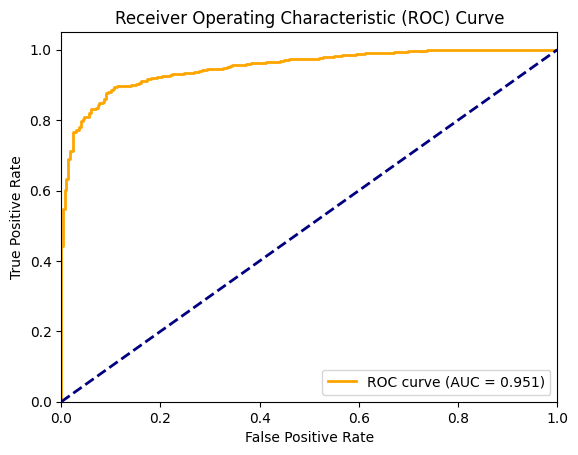

>>>>>     PCA(2), nu=0.5, gamma=0.001     <<<<<
AUC: 0.939, F1-score: 0.916, Accuracy: 0.877, FPR: 0.223, FNR: 0.085


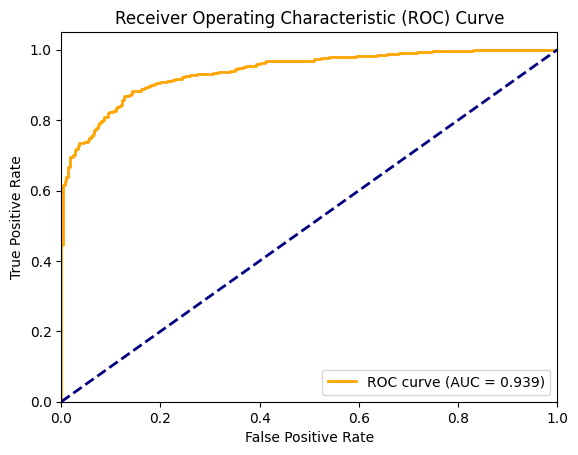

>>>>>     PCA(2), nu=0.5, gamma=0.01     <<<<<
AUC: 0.939, F1-score: 0.906, Accuracy: 0.854, FPR: 0.450, FNR: 0.032


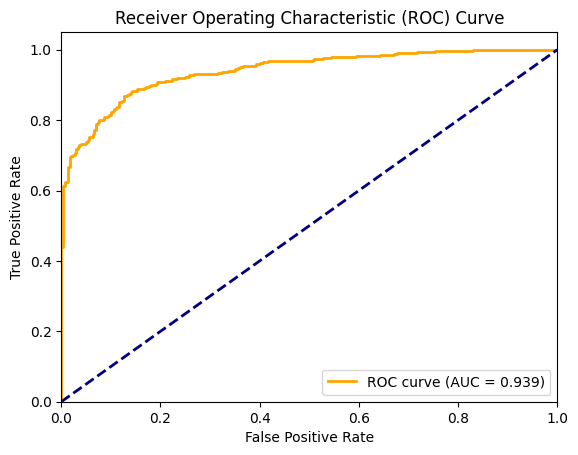

>>>>>     PCA(2), nu=0.5, gamma=0.1     <<<<<
AUC: 0.939, F1-score: 0.903, Accuracy: 0.849, FPR: 0.470, FNR: 0.031


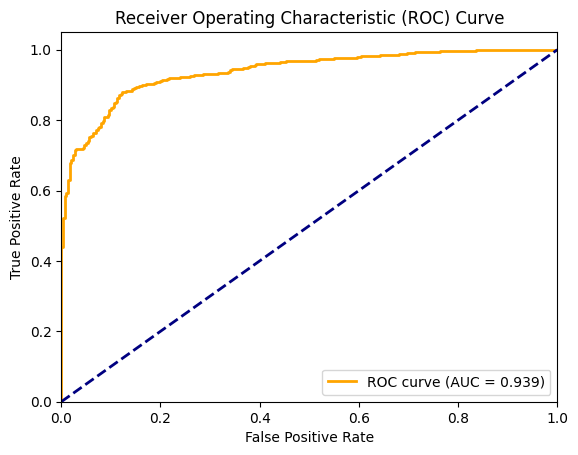

In [97]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, f1_score
from sklearn import svm

best_svm = None
best_auc = 0

pcas = [2]
nus = [0.1, 0.3, 0.5]
gammas = [1e-3, 1e-2, 1e-1]
threshold = 2

for nu in nus:
    for gamma in gammas:
        for pca_dims in pcas:
            print(f'>>>>>     PCA({pca_dims}), nu={nu}, gamma={gamma}     <<<<<')

            yTEtotal = []
            ypredtotal = []
            scorestotal = []

            models = dict()

            for id in ids:
                XTR = XTRfinal[id]
                XTE = XTEfinal[id]
                yTE = yTEdic[id]

                pca = PCA(n_components=pca_dims)
                XTR = pca.fit_transform(XTR)
                XTE = pca.transform(XTE)

                clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma, max_iter=10000)
                clf.fit(XTR)
                test_scores = 1-clf.decision_function(XTE)
                ypred = test_scores > threshold

                yTEtotal.extend(yTE)
                ypredtotal.extend(ypred)
                scorestotal.extend(test_scores)

                accuracy = accuracy_score(yTE, ypred)
                auc = roc_auc_score(yTE, test_scores)
                f1 = f1_score(yTE, ypred)
                conf_mat = confusion_matrix(yTE, ypred)
                TN, FP, FN, TP = conf_mat.ravel()
                fpr = FP / (FP + TN)
                fnr = FN / (FN + TP)

                # print(f'ID: {id}, AUC: {auc:.3f}, F1-score: {f1:.3f}, Accuracy: {accuracy:.3f}, FPR: {fpr:.3f}, FNR: {fnr:.3f}')

                models[id] = clf

            fprs, tprs, thresholds = roc_curve(yTEtotal, scorestotal)

            accuracy = accuracy_score(yTEtotal, ypredtotal)
            auc = roc_auc_score(yTEtotal, scorestotal)
            f1 = f1_score(yTEtotal, ypredtotal)
            conf_mat = confusion_matrix(yTEtotal, ypredtotal)
            TN, FP, FN, TP = conf_mat.ravel()
            fpr = FP / (FP + TN)
            fnr = FN / (FN + TP)

            print(f'AUC: {auc:.3f}, F1-score: {f1:.3f}, Accuracy: {accuracy:.3f}, FPR: {fpr:.3f}, FNR: {fnr:.3f}')

            # Plot the ROC curve
            plt.figure()
            plt.plot(fprs, tprs, color='orange', lw=2, label='ROC curve (AUC = %0.3f)' % auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

            if auc > best_auc:
                best_auc = auc
                best_svm = {
                    'pca': pca_dims,
                    'nu': nu,
                    'gamma': gamma,
                    'model': models,
                    'auc': auc,
                }

In [92]:
print(best_auc)
display(best_svm)

0.9657012068248023


{'pca': 2,
 'nu': 0.1,
 'gamma': 0.1,
 'model': {'00': OneClassSVM(gamma=0.1, max_iter=10000, nu=0.1),
  '02': OneClassSVM(gamma=0.1, max_iter=10000, nu=0.1),
  '04': OneClassSVM(gamma=0.1, max_iter=10000, nu=0.1)},
 'auc': 0.9657012068248023}

>>>>>     PCA(2) | GMM components: 4 | Covariance: full     <<<<<


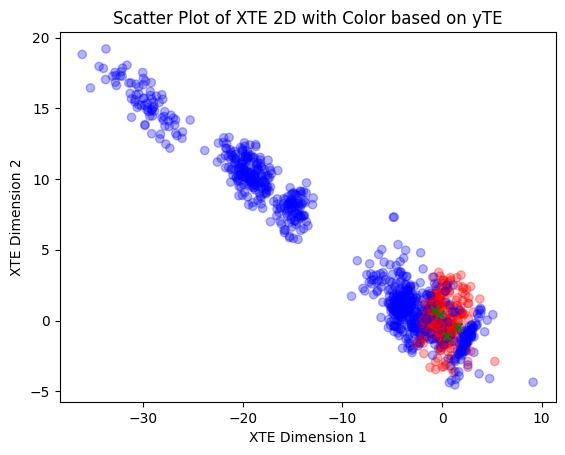

AUC: 0.955
>>>>>     PCA(2) | GMM components: 4 | Covariance: diag     <<<<<


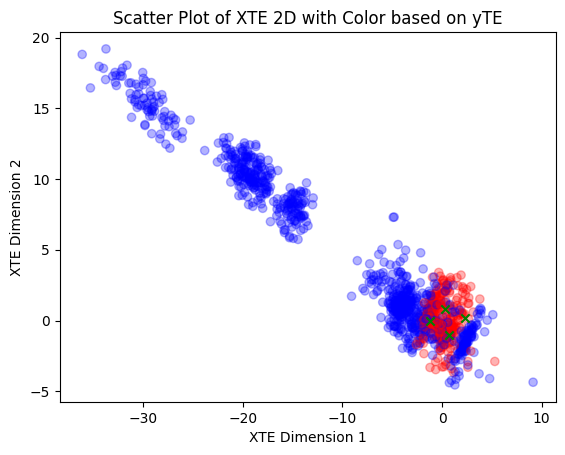

AUC: 0.948
>>>>>     PCA(2) | GMM components: 8 | Covariance: full     <<<<<


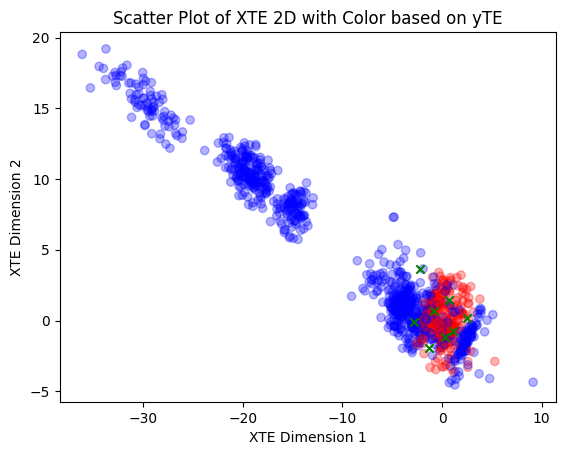

AUC: 0.960
>>>>>     PCA(2) | GMM components: 8 | Covariance: diag     <<<<<


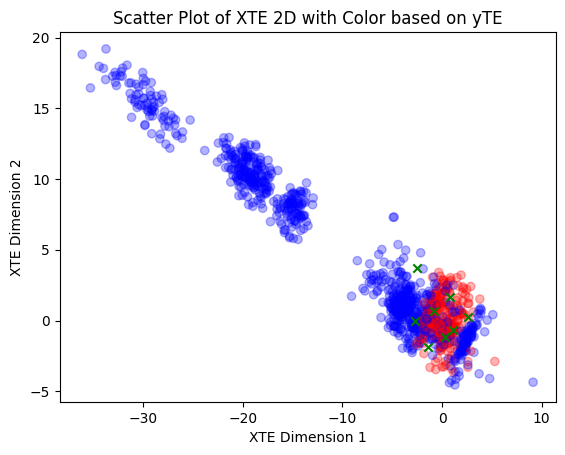

AUC: 0.960
>>>>>     PCA(2) | GMM components: 16 | Covariance: full     <<<<<


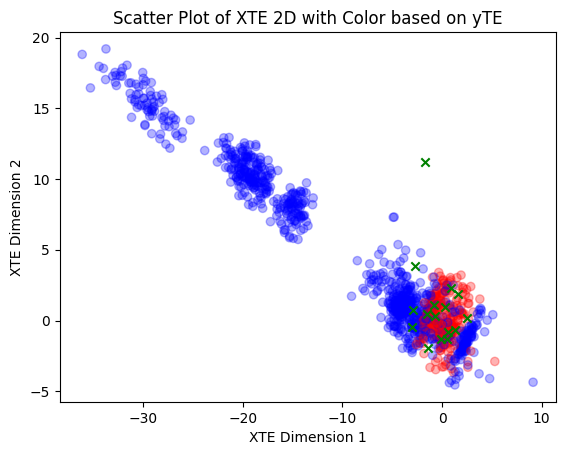

AUC: 0.961
>>>>>     PCA(2) | GMM components: 16 | Covariance: diag     <<<<<


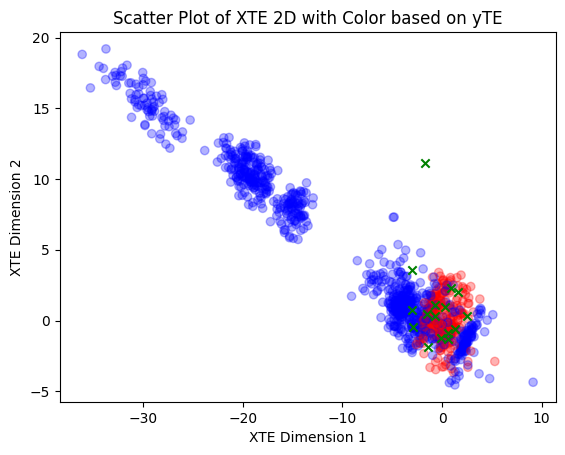

AUC: 0.962
>>>>>     PCA(3) | GMM components: 4 | Covariance: full     <<<<<
AUC: 0.956
>>>>>     PCA(3) | GMM components: 4 | Covariance: diag     <<<<<
AUC: 0.948
>>>>>     PCA(3) | GMM components: 8 | Covariance: full     <<<<<
AUC: 0.954
>>>>>     PCA(3) | GMM components: 8 | Covariance: diag     <<<<<
AUC: 0.951
>>>>>     PCA(3) | GMM components: 16 | Covariance: full     <<<<<
AUC: 0.956
>>>>>     PCA(3) | GMM components: 16 | Covariance: diag     <<<<<
AUC: 0.958


In [77]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

best_auc = 0
best_gmm_all_ids= None

nums_components = [4, 8, 16]
pcas = [2, 3]
covariances = ['full', 'diag']

for pca_dims in pcas:
    for n_components in nums_components:
        for cov in covariances:
            print(f'>>>>>     PCA({pca_dims}) | GMM components: {n_components} | Covariance: {cov}     <<<<<')
            XTR = np.vstack([XTRfinal[id] for id in ids])
            XTE = np.vstack([XTEfinal[id] for id in ids])
            yTE = np.hstack([yTEdic[id] for id in ids])

            pca = PCA(n_components=pca_dims)
            XTR = pca.fit_transform(XTR)
            XTE = pca.transform(XTE)

            gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE, max_iter=10000, covariance_type=cov)

            gmm.fit(XTR)

            if pca_dims == 2:
                import matplotlib.pyplot as plt

                # Extract X and y values
                XTE_x = XTE[:, 0]
                XTE_y = XTE[:, 1]
                yTE_colors = np.where(yTE == 0, 'red', 'blue')

                # Create scatter plot
                plt.scatter(XTE_y, XTE_x, c=yTE_colors, alpha=0.3)
                
                 # Assuming gmm is the Gaussian Mixture Model object
                means = gmm.means_

                # Plot the scatter points
                plt.scatter(means[:, 0], means[:, 1], c='green', marker='x', label='GMM Means')

                # Add labels and title
                plt.xlabel('XTE Dimension 1')
                plt.ylabel('XTE Dimension 2')
                plt.title('Scatter Plot of XTE 2D with Color based on yTE')

                # Show the plot
                plt.show()

            test_scores = 1-gmm.score_samples(XTE)
            auc = roc_auc_score(yTE, test_scores)
            print(f'AUC: {auc:.3f}')

            # # Plot the ROC curve
            # plt.figure()
            # plt.plot(fprs, tprs, color='orange', lw=2, label='ROC curve (AUC = %0.3f)' % auc)
            # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            # plt.xlim([0.0, 1.0])
            # plt.ylim([0.0, 1.05])
            # plt.xlabel('False Positive Rate')
            # plt.ylabel('True Positive Rate')
            # plt.title('Receiver Operating Characteristic (ROC) Curve')
            # plt.legend(loc="lower right")
            # plt.show()

            if auc > best_auc:
                best_auc = auc
                best_gmm_all_ids = {
                    'pca': pca_dims,
                    'n_components': n_components,
                    'covariance': cov,
                    'gmm': gmm,
                    'auc': auc,
                }

In [66]:
print(best_auc)
display(best_gmm_all_ids)

model = best_gmm_all_ids['gmm']
means = model.means_
dists = []
mind = 1000
for i in range(len(means)):
    for j in range(i+1, len(means)):
        dists.append(euclidean(means[i], means[j]))
display(sorted(dists))

0.9616812317935913


{'pca': 2,
 'n_components': 16,
 'covariance': 'diag',
 'gmm': GaussianMixture(covariance_type='diag', max_iter=10000, n_components=16,
                 random_state=42),
 'auc': 0.9616812317935913}

[0.373617548781844,
 0.6933527601321564,
 0.7349631840047478,
 0.7590167265800962,
 0.7931065951532107,
 0.7948626329846006,
 0.8236691822724403,
 0.9914988569397067,
 1.0543927760475849,
 1.0608052507296617,
 1.1556088755325713,
 1.2582728647051757,
 1.4551676001027303,
 1.4895448184940576,
 1.4923942993178116,
 1.5402050711954989,
 1.5537980922274892,
 1.6266481086136575,
 1.6709511815915337,
 1.681873694018737,
 1.829581148509709,
 1.8494180763728851,
 1.89404422421063,
 1.9232131072832863,
 1.962921677880571,
 2.015003229091914,
 2.075156797700939,
 2.0778186402525853,
 2.1296458019963502,
 2.2168651226365,
 2.2367776196027234,
 2.248736456340986,
 2.252559195355668,
 2.259467446931759,
 2.2781365336859665,
 2.287256819289594,
 2.291599279328105,
 2.294570121907496,
 2.328786418584112,
 2.3332820364462625,
 2.3495119518173184,
 2.4402341432017556,
 2.4553295217154862,
 2.4766062999492733,
 2.502284855644412,
 2.5415214996394835,
 2.5574554601431414,
 2.5944615270782183,
 2.64425304

>>>>>     PCA(2), nu=0.1, gamma=0.001     <<<<<
AUC: 0.940


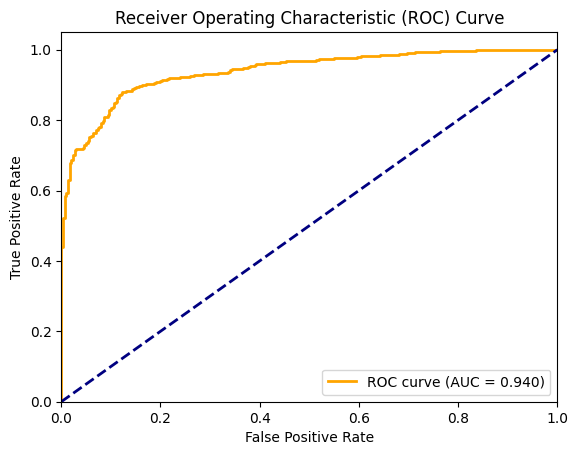

>>>>>     PCA(3), nu=0.1, gamma=0.001     <<<<<
AUC: 0.935


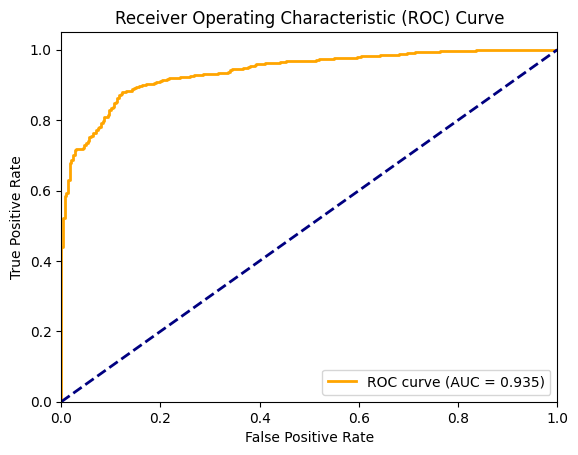

>>>>>     PCA(2), nu=0.1, gamma=0.01     <<<<<
AUC: 0.942


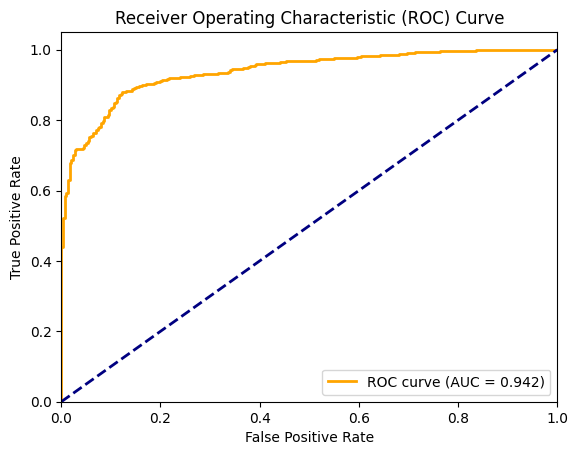

>>>>>     PCA(3), nu=0.1, gamma=0.01     <<<<<
AUC: 0.937


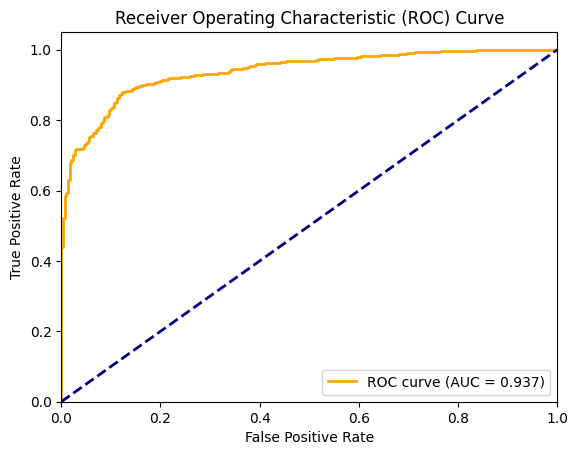

>>>>>     PCA(2), nu=0.1, gamma=0.1     <<<<<
AUC: 0.953


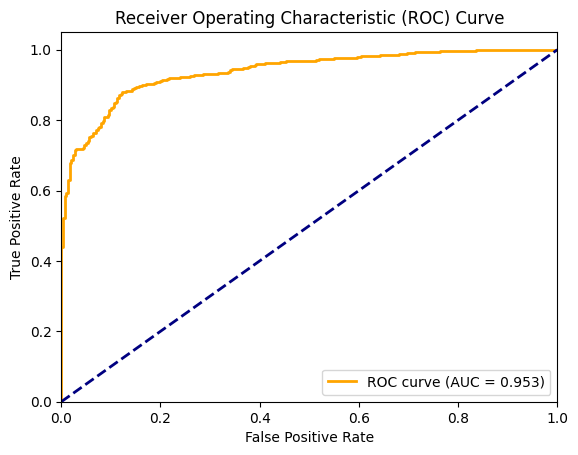

>>>>>     PCA(3), nu=0.1, gamma=0.1     <<<<<
AUC: 0.951


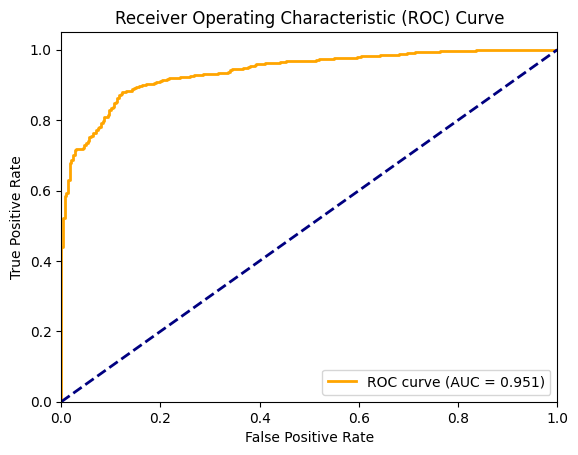

>>>>>     PCA(2), nu=0.3, gamma=0.001     <<<<<
AUC: 0.942


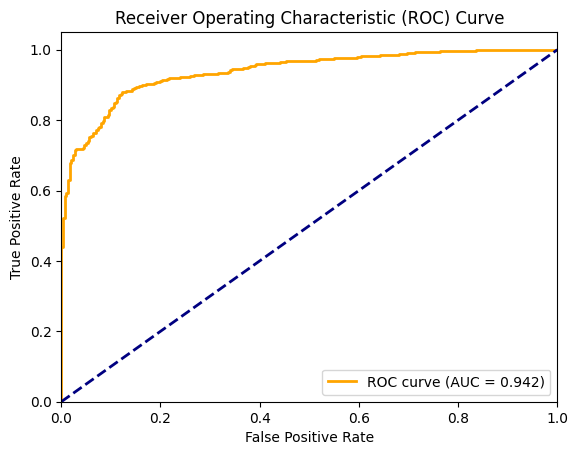

>>>>>     PCA(3), nu=0.3, gamma=0.001     <<<<<
AUC: 0.938


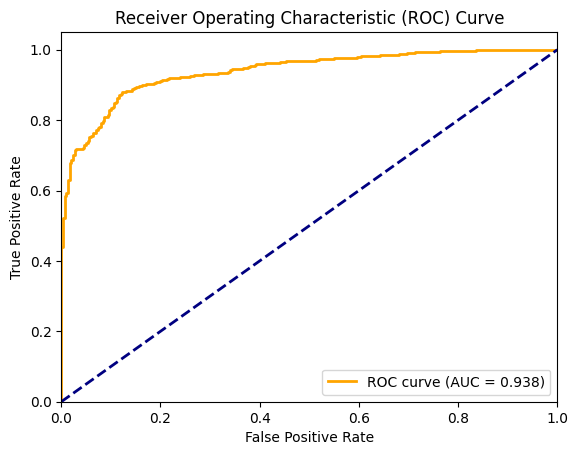

>>>>>     PCA(2), nu=0.3, gamma=0.01     <<<<<
AUC: 0.943


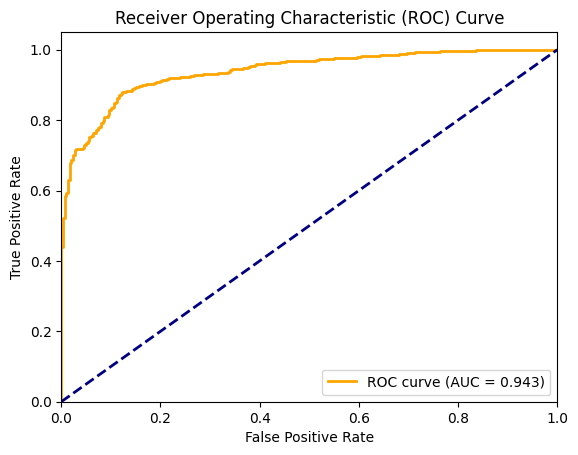

>>>>>     PCA(3), nu=0.3, gamma=0.01     <<<<<
AUC: 0.939


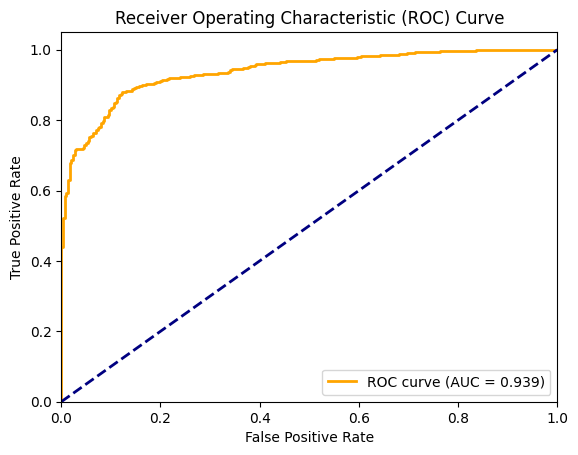

>>>>>     PCA(2), nu=0.3, gamma=0.1     <<<<<
AUC: 0.952


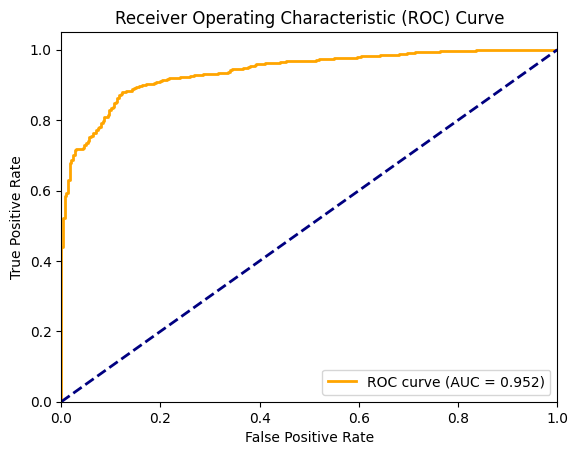

>>>>>     PCA(3), nu=0.3, gamma=0.1     <<<<<
AUC: 0.948


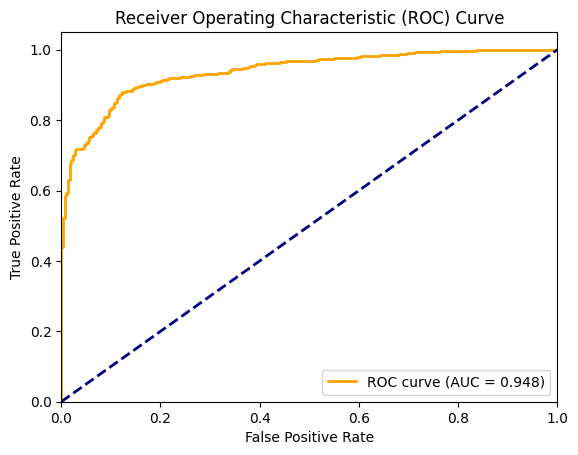

>>>>>     PCA(2), nu=0.5, gamma=0.001     <<<<<
AUC: 0.942


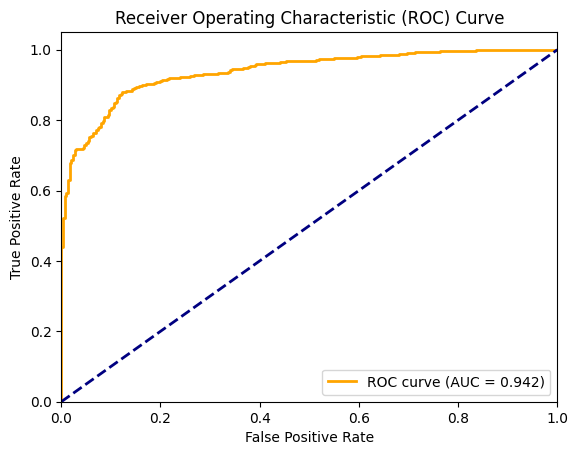

>>>>>     PCA(3), nu=0.5, gamma=0.001     <<<<<
AUC: 0.938


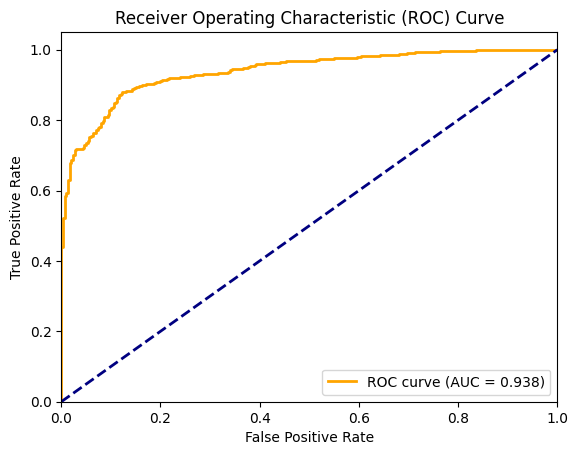

>>>>>     PCA(2), nu=0.5, gamma=0.01     <<<<<
AUC: 0.942


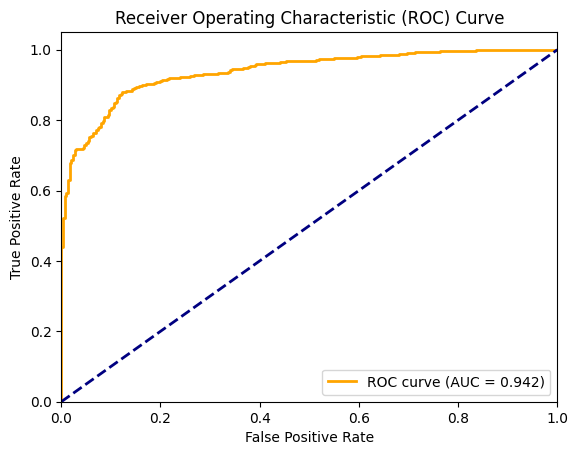

>>>>>     PCA(3), nu=0.5, gamma=0.01     <<<<<
AUC: 0.939


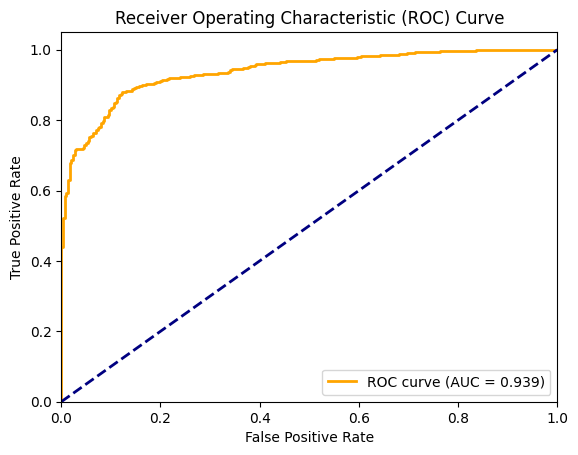

>>>>>     PCA(2), nu=0.5, gamma=0.1     <<<<<
AUC: 0.947


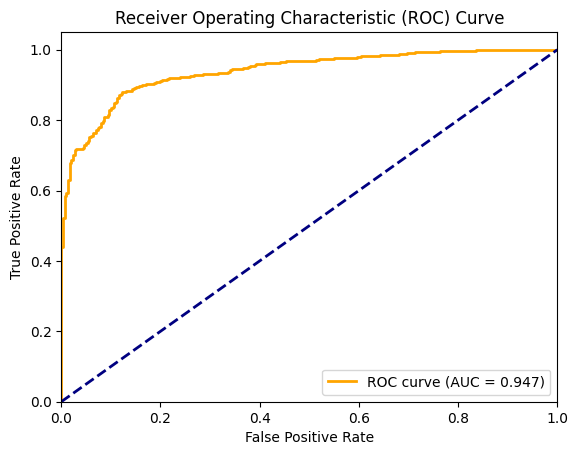

>>>>>     PCA(3), nu=0.5, gamma=0.1     <<<<<
AUC: 0.944


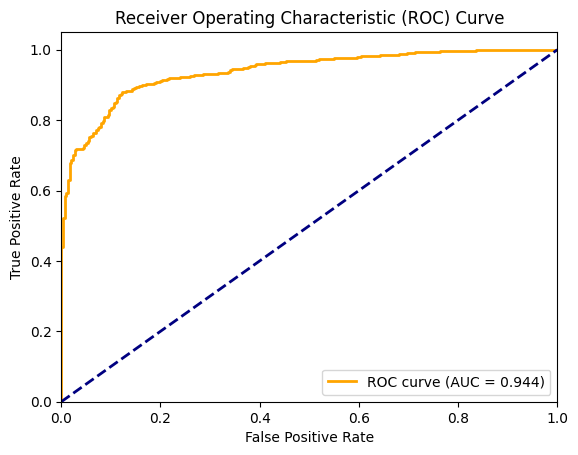

In [95]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, f1_score
from sklearn import svm

best_auc = 0
best_svm_all_ids = None

pcas = [2, 3]
nus = [0.1, 0.3, 0.5]
gammas = [1e-3, 1e-2, 1e-1]
threshold = 2

for nu in nus:
    for gamma in gammas:
        for pca_dims in pcas:
            print(f'>>>>>     PCA({pca_dims}), nu={nu}, gamma={gamma}     <<<<<')
            XTR = np.vstack([XTRfinal[id] for id in ids])
            XTE = np.vstack([XTEfinal[id] for id in ids])
            yTE = np.hstack([yTEdic[id] for id in ids])

            pca = PCA(n_components=pca_dims)
            XTR = pca.fit_transform(XTR)
            XTE = pca.transform(XTE)

            clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma, max_iter=10000)
            clf.fit(XTR)
            test_scores = 1-clf.decision_function(XTE)
            auc = roc_auc_score(yTE, test_scores)
            
            print(f'AUC: {auc:.3f}')

            # Plot the ROC curve
            plt.figure()
            plt.plot(fprs, tprs, color='orange', lw=2, label='ROC curve (AUC = %0.3f)' % auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

            if auc > best_auc:
                best_auc = auc
                best_svm_all_ids = {
                    'pca': pca_dims,
                    'nu': nu,
                    'gamma': gamma,
                    'clf': clf,
                    'auc': auc,
                }

In [96]:
print(best_auc)
display(best_svm_all_ids)

0.9528006658343737


{'pca': 2,
 'nu': 0.1,
 'gamma': 0.1,
 'clf': OneClassSVM(gamma=0.1, max_iter=10000, nu=0.1),
 'auc': 0.9528006658343737}